In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_validate,validation_curve
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score



warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn-dataset/Bank Customer Churn Prediction.csv


In [2]:
df = pd.read_csv("/kaggle/input/bank-customer-churn-dataset/Bank Customer Churn Prediction.csv")

In [3]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [6]:
df.shape

(10000, 12)

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=30):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes not in ["O", 'datetime64[ns]']]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    binary_cols = [col for col in dataframe.columns if
                   dataframe[col].dtype not in [int, float] and dataframe[col].nunique() == 2]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    print(f'binary_cols: {len(binary_cols)}')

    return cat_cols, num_cols, cat_but_car, binary_cols

result = grab_col_names(df)
cat_cols, num_cols, cat_but_car = result[0], result[1], result[2]

Observations: 10000
Variables: 12
cat_cols: 6
num_cols: 6
cat_but_car: 0
num_but_cat: 4
binary_cols: 1


In [8]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

         country  Ratio
country                
France      5014  50.14
Germany     2509  25.09
Spain       2477  24.77
##########################################


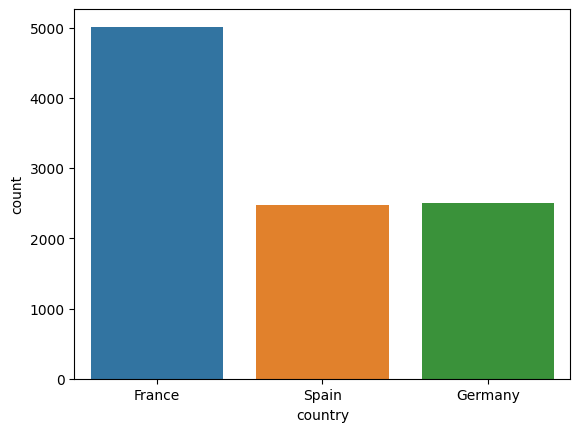

        gender  Ratio
gender               
Male      5457  54.57
Female    4543  45.43
##########################################


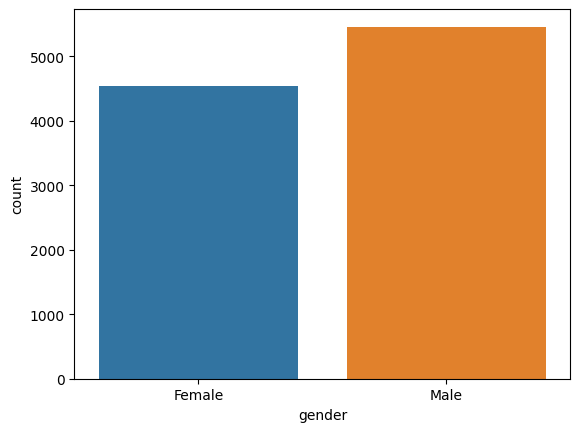

                 products_number  Ratio
products_number                        
1                           5084  50.84
2                           4590  45.90
3                            266   2.66
4                             60   0.60
##########################################


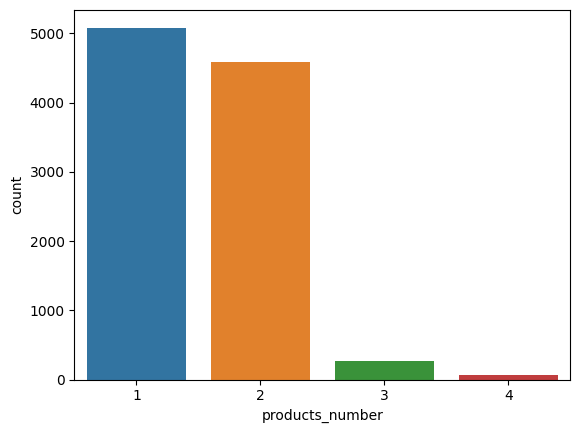

             credit_card  Ratio
credit_card                    
1                   7055  70.55
0                   2945  29.45
##########################################


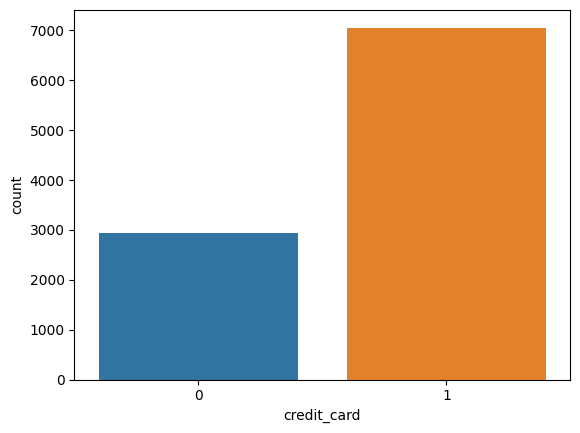

               active_member  Ratio
active_member                      
1                       5151  51.51
0                       4849  48.49
##########################################


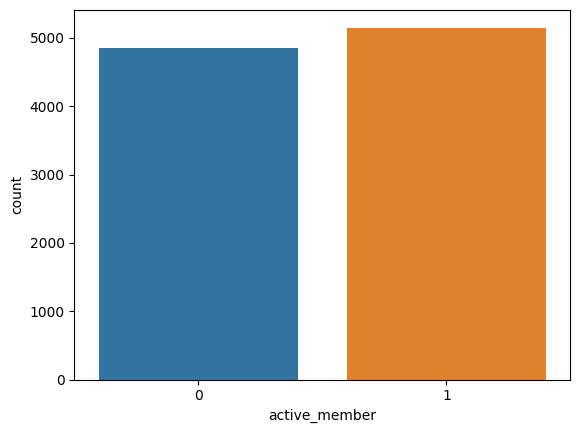

       churn  Ratio
churn              
0       7963  79.63
1       2037  20.37
##########################################


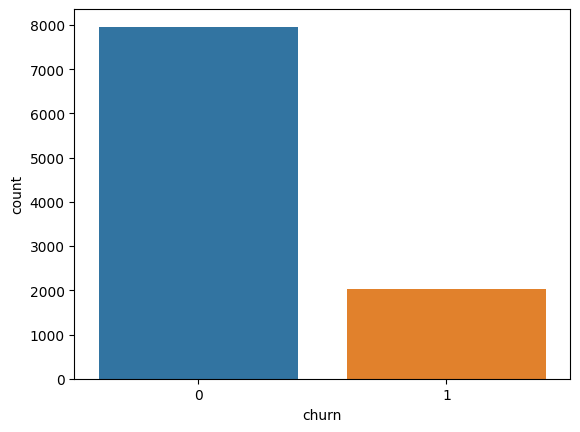

In [9]:
for col in cat_cols:
    cat_summary(df,col, plot=True)

In [10]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count    1.000000e+04
mean     1.569094e+07
std      7.193619e+04
min      1.556570e+07
5%       1.557882e+07
10%      1.559117e+07
20%      1.561638e+07
30%      1.564136e+07
40%      1.566579e+07
50%      1.569074e+07
60%      1.571569e+07
70%      1.574046e+07
80%      1.576582e+07
90%      1.579083e+07
95%      1.580303e+07
99%      1.581311e+07
max      1.581569e+07
Name: customer_id, dtype: float64


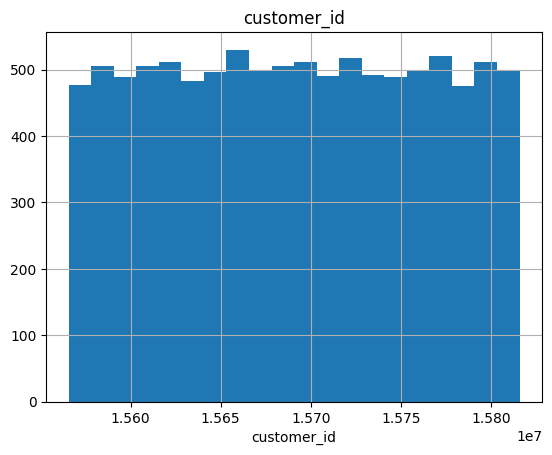

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
5%         489.000000
10%        521.000000
20%        566.000000
30%        598.700000
40%        627.000000
50%        652.000000
60%        678.000000
70%        704.000000
80%        735.000000
90%        778.000000
95%        812.000000
99%        850.000000
max        850.000000
Name: credit_score, dtype: float64


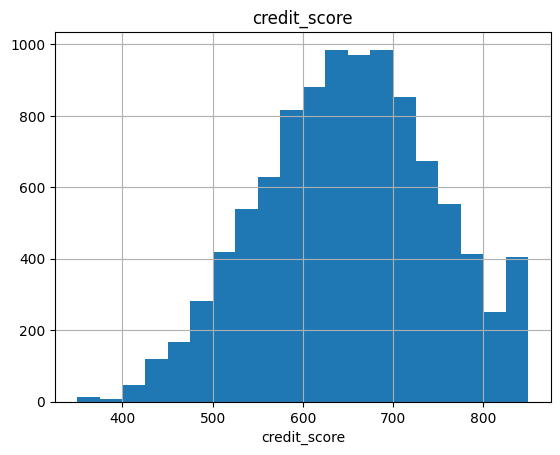

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
5%          25.000000
10%         27.000000
20%         31.000000
30%         33.000000
40%         35.000000
50%         37.000000
60%         40.000000
70%         42.000000
80%         46.000000
90%         53.000000
95%         60.000000
99%         72.000000
max         92.000000
Name: age, dtype: float64


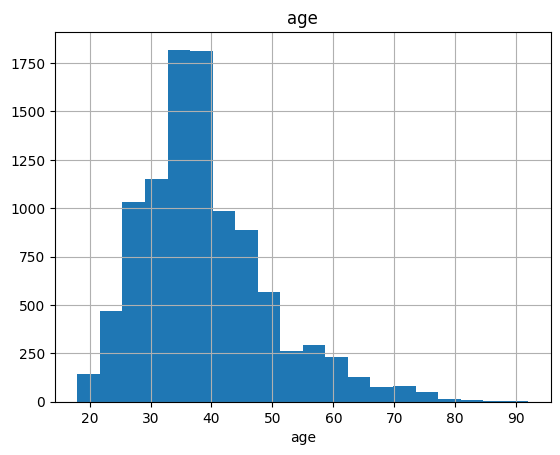

count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
5%           1.000000
10%          1.000000
20%          2.000000
30%          3.000000
40%          4.000000
50%          5.000000
60%          6.000000
70%          7.000000
80%          8.000000
90%          9.000000
95%          9.000000
99%         10.000000
max         10.000000
Name: tenure, dtype: float64


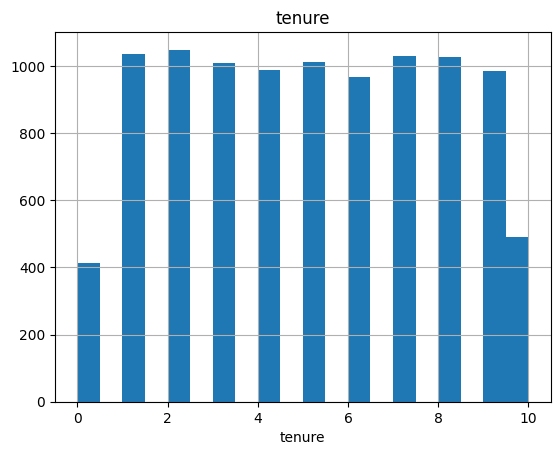

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
5%            0.000000
10%           0.000000
20%           0.000000
30%           0.000000
40%       73080.908000
50%       97198.540000
60%      110138.926000
70%      122029.870000
80%      133710.358000
90%      149244.792000
95%      162711.669000
99%      185967.985400
max      250898.090000
Name: balance, dtype: float64


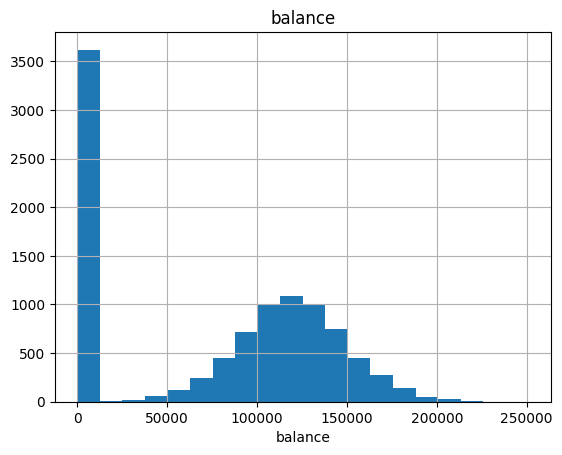

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
5%         9851.818500
10%       20273.580000
20%       41050.736000
30%       60736.079000
40%       80238.340000
50%      100193.915000
60%      119710.038000
70%      139432.236000
80%      159836.726000
90%      179674.704000
95%      190155.375500
99%      198069.734500
max      199992.480000
Name: estimated_salary, dtype: float64


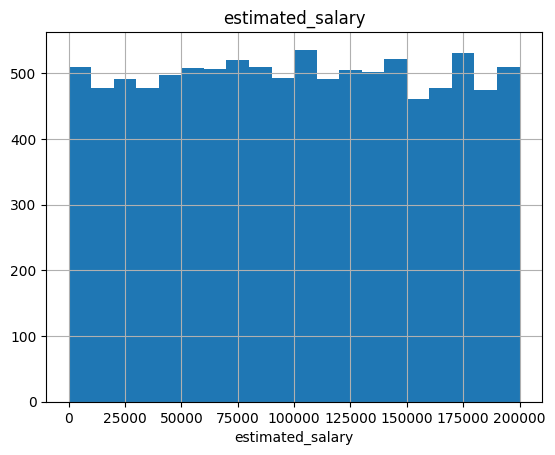

In [11]:
for col in num_cols:
    num_summary(df,col,plot=True)

In [12]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [13]:
for col in num_cols:
    target_summary_with_num(df ,"churn" , col)

        customer_id
churn              
0      1.569117e+07
1      1.569005e+07


       credit_score
churn              
0        651.853196
1        645.351497


             age
churn           
0      37.408389
1      44.837997


         tenure
churn          
0      5.033279
1      4.932744


            balance
churn              
0      72745.296779
1      91108.539337


       estimated_salary
churn                  
0          99738.391772
1         101465.677531




In [14]:
for col in cat_cols:
    target_summary_with_cat(df,"churn",col)

         TARGET_MEAN
country             
France      0.161548
Germany     0.324432
Spain       0.166734


        TARGET_MEAN
gender             
Female     0.250715
Male       0.164559


                 TARGET_MEAN
products_number             
1                   0.277144
2                   0.075817
3                   0.827068
4                   1.000000


             TARGET_MEAN
credit_card             
0               0.208149
1               0.201843


               TARGET_MEAN
active_member             
0                 0.268509
1                 0.142691


       TARGET_MEAN
churn             
0              0.0
1              1.0




In [15]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

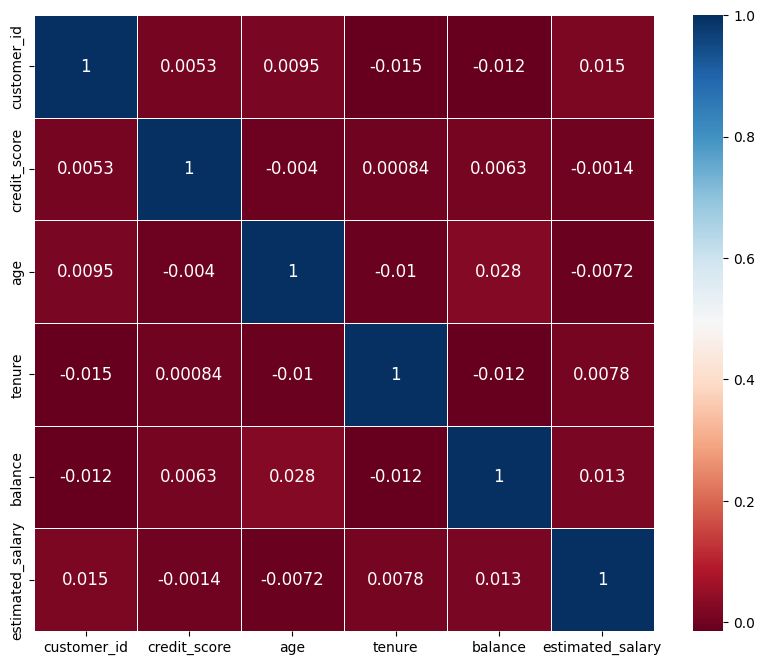

In [16]:
correlation_matrix(df, num_cols)


In [17]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, 'churn', cat_cols=cat_cols)

country : 3
         COUNT   RATIO  TARGET_MEAN
country                            
France    5014  0.5014     0.161548
Germany   2509  0.2509     0.324432
Spain     2477  0.2477     0.166734


gender : 2
        COUNT   RATIO  TARGET_MEAN
gender                            
Female   4543  0.4543     0.250715
Male     5457  0.5457     0.164559


products_number : 4
                 COUNT   RATIO  TARGET_MEAN
products_number                            
1                 5084  0.5084     0.277144
2                 4590  0.4590     0.075817
3                  266  0.0266     0.827068
4                   60  0.0060     1.000000


credit_card : 2
             COUNT   RATIO  TARGET_MEAN
credit_card                            
0             2945  0.2945     0.208149
1             7055  0.7055     0.201843


active_member : 2
               COUNT   RATIO  TARGET_MEAN
active_member                            
0               4849  0.4849     0.268509
1               5151  0.5151     0.142691


c

<Axes: >

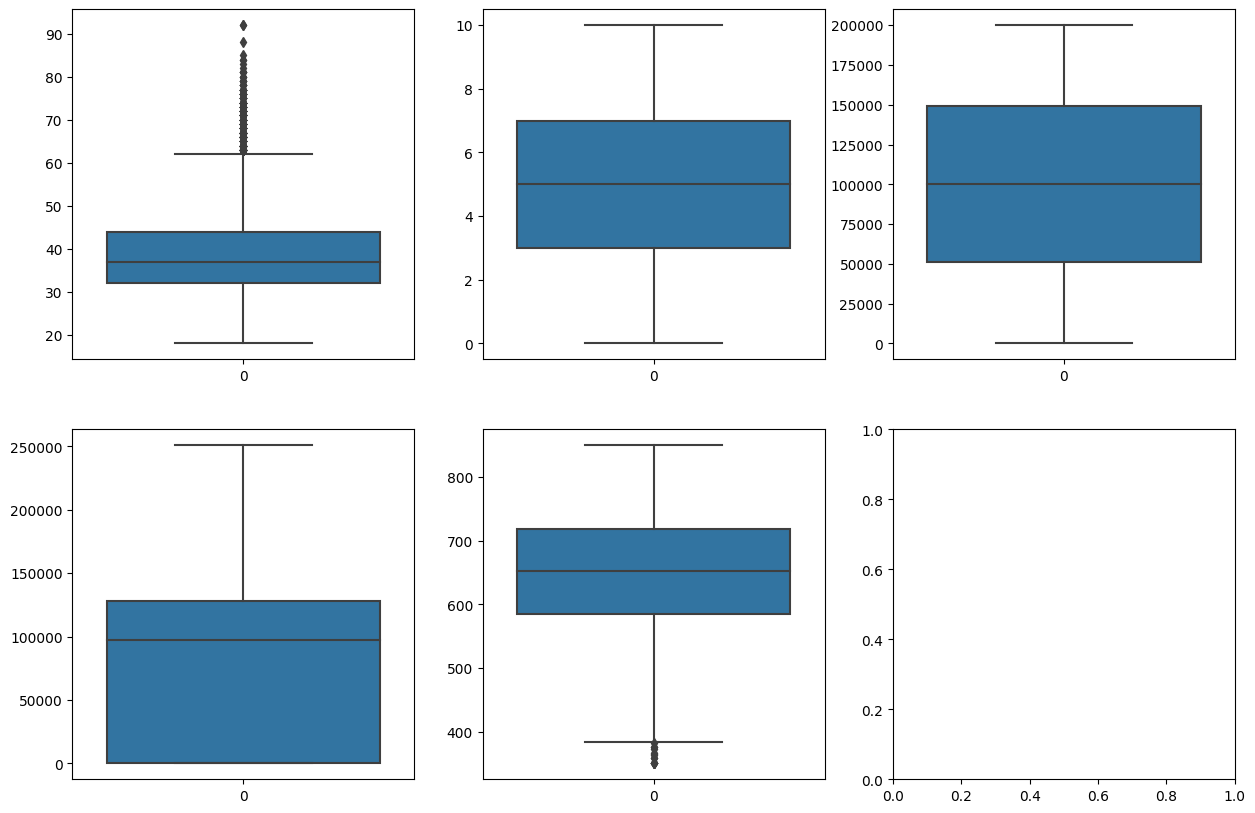

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
sns.boxplot(data=df['age'], ax=ax[0][0])
sns.boxplot(data=df['tenure'], ax=ax[0][1])
sns.boxplot(data=df['estimated_salary'], ax=ax[0][2])
sns.boxplot(data=df['balance'], ax=ax[1][0])
sns.boxplot(data=df['credit_score'], ax=ax[1][1])

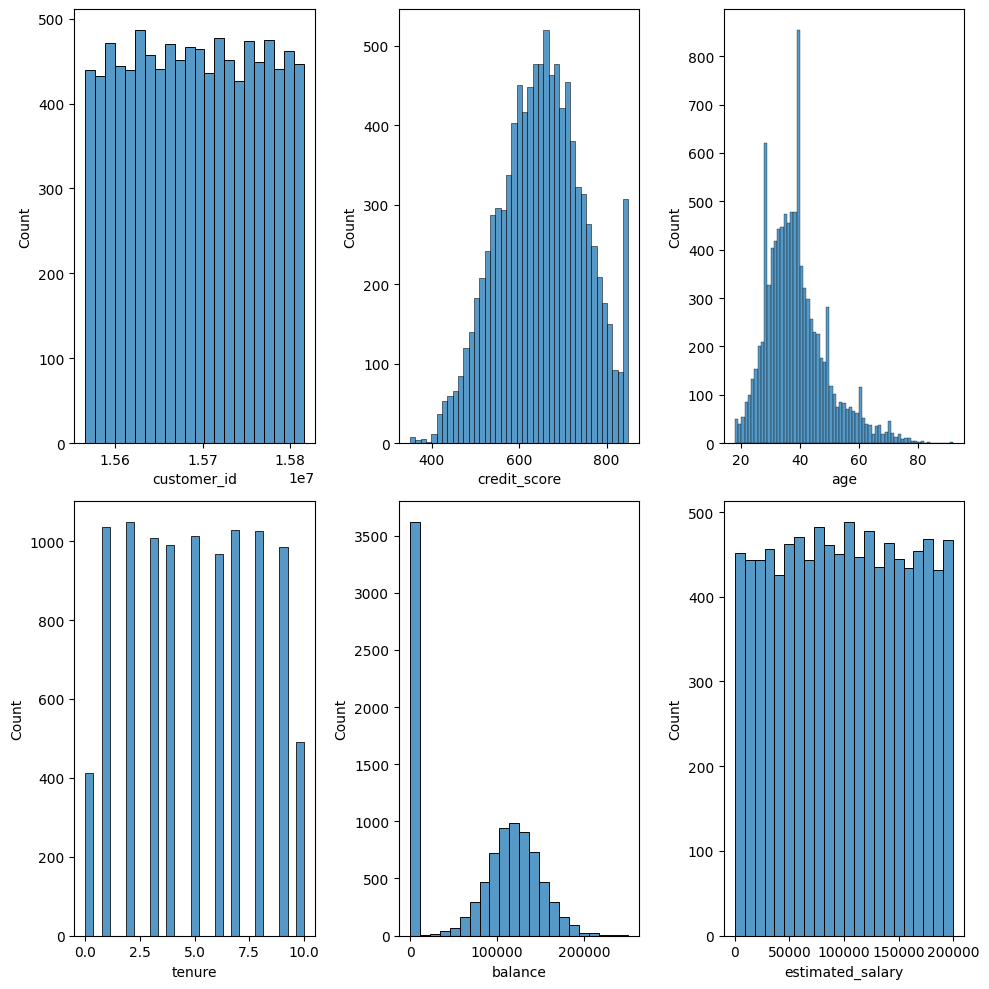

In [19]:
def plot_numerical_col(dataframe, num_cols, plot_type='hist'):
    num_cols_count = len(num_cols)
    num_rows = num_cols_count // 3
    num_rows += 1 if num_cols_count % 3 != 0 else 0  # Eğer sütun sayısı 3'e tam bölünmüyorsa bir ek satır oluştur.


    col_groups = [num_cols[i:i+12] for i in range(0, num_cols_count, 12)]

    for group in col_groups:
        fig, axes = plt.subplots(num_rows, 3, figsize=(10, 10))
        axes = axes.flatten()

        for i, col in enumerate(group):
            if plot_type == 'hist':
                sns.histplot(data=dataframe[col], ax=axes[i])
            elif plot_type == 'kde':
                sns.kdeplot(data=dataframe[col], ax=axes[i])
            elif plot_type == 'box':
                sns.boxplot(data=dataframe[col], ax=axes[i])
            else:
                print("Geçersiz grafik türü. Lütfen 'hist', 'kde', veya 'box' olarak belirtin.")
                return
            axes[i].set_xlabel(col)

        for j in range(len(group), num_rows * 3):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
        
plot_numerical_col(df, num_cols)

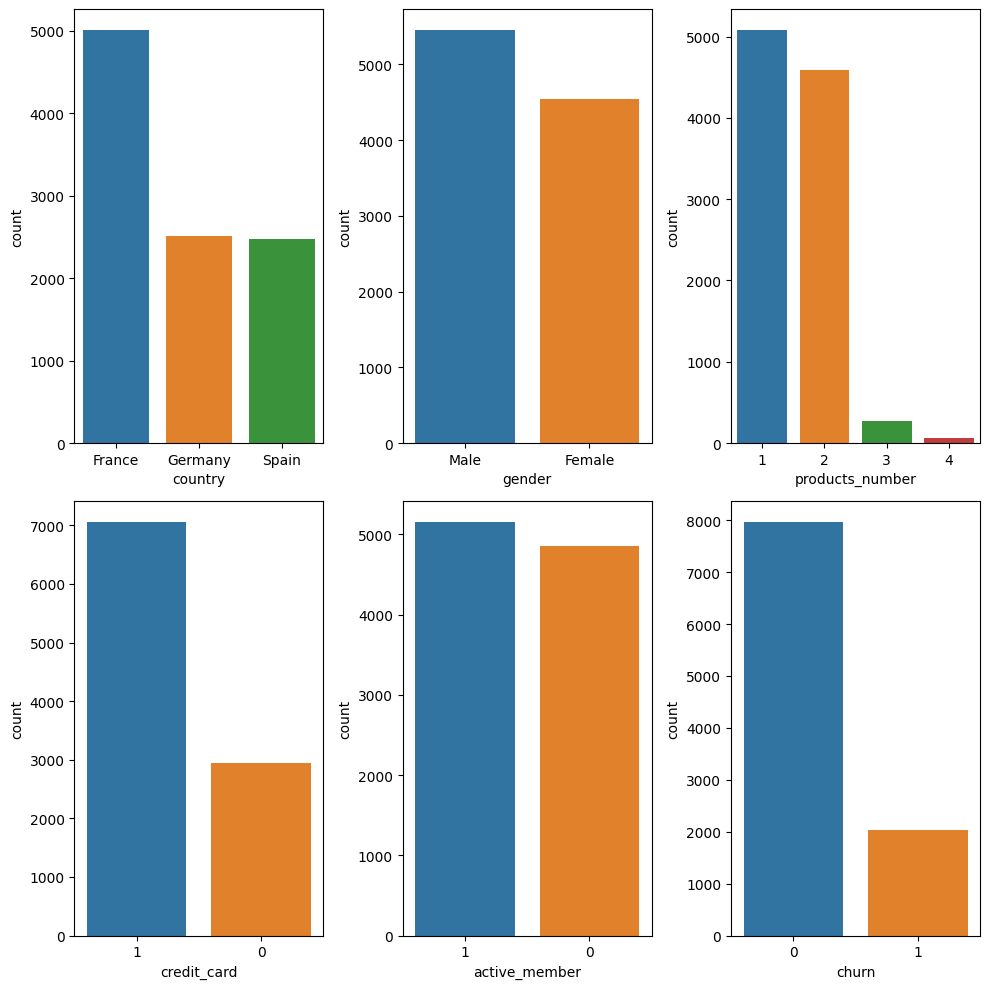

In [20]:
def plot_categoric_col(dataframe, cat_cols):
    cat_cols_count = len(cat_cols)
    cat_rows = cat_cols_count // 3
    cat_rows += 1 if cat_cols_count % 3 != 0 else 0  # Eğer sütun sayısı 3'e tam bölünmüyorsa bir ek satır oluştur.

    fig, axes = plt.subplots(cat_rows, 3, figsize=(10, 10), squeeze=True)
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        sns.countplot(data=dataframe, x=col, ax=axes[i], order=dataframe[col].value_counts().index)
        axes[i].set_xlabel(col)

    plt.tight_layout()
    plt.show()

plot_categoric_col(df, cat_cols=cat_cols)

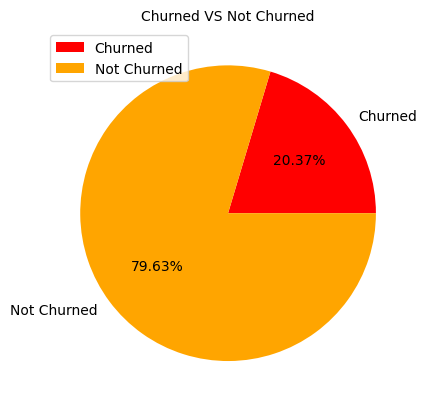

In [21]:
sizes = [df.churn[df['churn']==1].count(), df.churn[df['churn']==0].count()]
labels = ['Churned', 'Not Churned']
colors = ['red', 'orange']

plt.pie(sizes, labels=labels, autopct='%.2f%%', colors=colors)
plt.legend(loc='upper left')
plt.title("Churned VS Not Churned", size=10)
plt.show()

In [22]:
df.loc[df['products_number'] == 4, 'products_number'] = 3


df['credit_score_seg'] = pd.cut(df['credit_score'], bins=[349, 500, 590, 620, 660, 690, 720, np.inf],
                                labels=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

df['balance_seg'] = pd.cut(df['balance'], bins=[-1, 50000, 90000, 127000, np.inf],
                           labels=['A', 'B', 'C', 'D'])

df['age_seg'] = pd.cut(df['age'], bins=[17, 36, 55, np.inf],
                       labels=['A', 'B', 'C'])

df['tenure_seg'] = pd.cut(df['tenure'], bins=[-1, 3, 5, 7, np.inf],
                          labels=['A', 'B', 'C', 'D'])

df_final = df.drop('customer_id', axis=1)

In [23]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype=int)
    return dataframe

def label_encoder(dataframe, binary_col, info=False):
    labelencoder = LabelEncoder()

    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    if info:
        d1, d2 = labelencoder.inverse_transform([0, 1])
        print(f'{binary_col}\n0:{d1}, 1:{d2}')
    return dataframe

In [24]:
df = one_hot_encoder(df, ['country', 'gender','age_seg'], drop_first=True)

label_encoder(df, 'credit_score_seg')
label_encoder(df, 'balance_seg')
label_encoder(df, 'tenure_seg')

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,credit_score_seg,balance_seg,tenure_seg,country_Germany,country_Spain,gender_Male,age_seg_B,age_seg_C
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,2,0,0,0,0,0,1,0
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,2,1,0,0,1,0,1,0
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,1,3,3,0,0,0,1,0
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,5,0,0,0,0,0,1,0
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,6,2,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,39,5,0.00,2,1,0,96270.64,0,6,0,1,0,0,1,1,0
9996,15569892,516,35,10,57369.61,1,1,1,101699.77,0,1,1,3,0,0,1,0,0
9997,15584532,709,36,7,0.00,1,0,1,42085.58,1,5,0,2,0,0,0,0,0
9998,15682355,772,42,3,75075.31,2,1,0,92888.52,1,6,1,0,1,0,1,1,0


In [25]:
y = df['churn']
X = df.drop(columns=['churn'], axis=1)

In [26]:
model = LGBMClassifier(verbose=-1).fit(X, y)
cv_results = cross_validate(model, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
f1 = cv_results['test_f1'].mean()
auc = cv_results['test_roc_auc'].mean()
accuracy = cv_results['test_accuracy'].mean()
print(f'f1: {f1:.2f}')
print(f'auc: {auc:.2f}')
print(f'accuracy: {accuracy:.2f}')

f1: 0.58
auc: 0.86
accuracy: 0.86


In [27]:
lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

gs_best = GridSearchCV(model, lightgbm_params, cv=3, n_jobs=-1, verbose=False).fit(X, y)
final_model = model.set_params(**gs_best.best_params_)

cv_results = cross_validate(final_model, X, y, cv=3, scoring=['accuracy', 'f1', 'roc_auc'])
f1 = cv_results['test_f1'].mean()
auc = cv_results['test_roc_auc'].mean()
accuracy = cv_results['test_accuracy'].mean()

print(f'f1: {f1:.2f}')
print(f'auc: {auc:.2f}')
print(f'accuracy: {accuracy:.2f}')

f1: 0.58
auc: 0.86
accuracy: 0.86


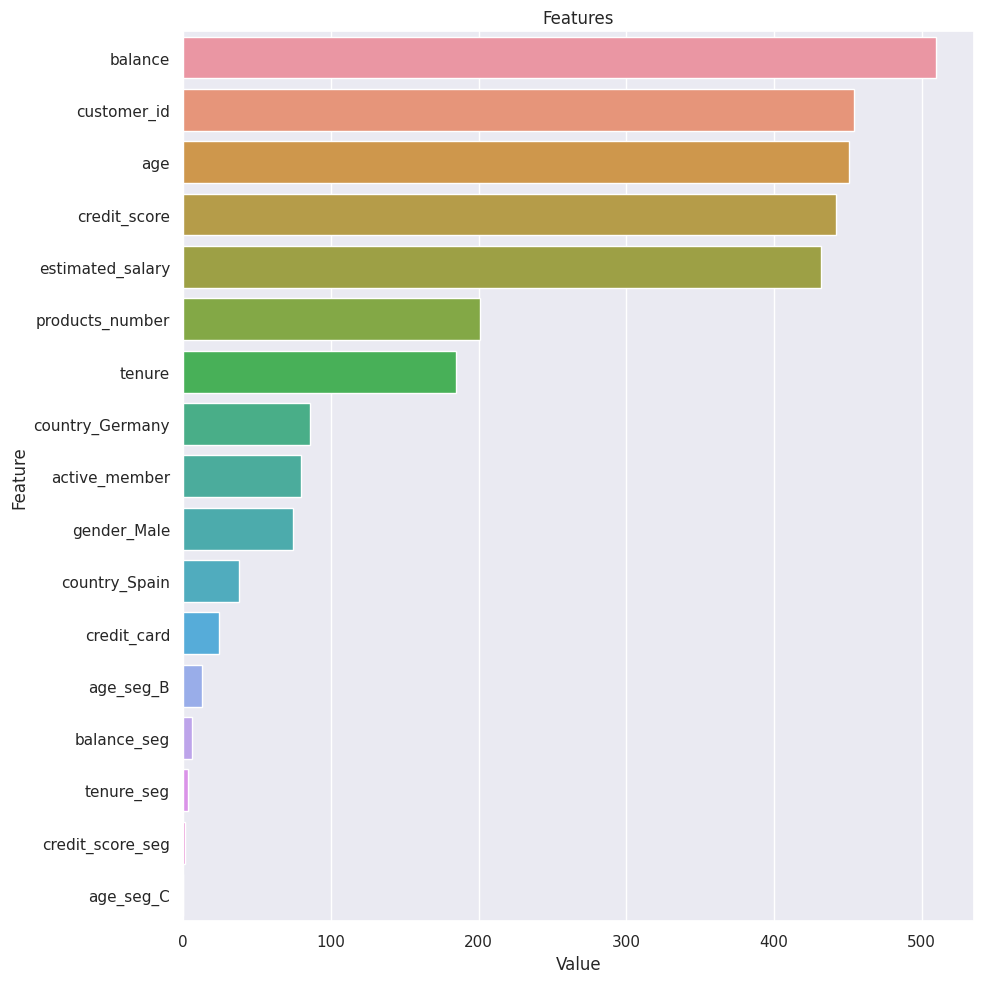

In [28]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(model, X)

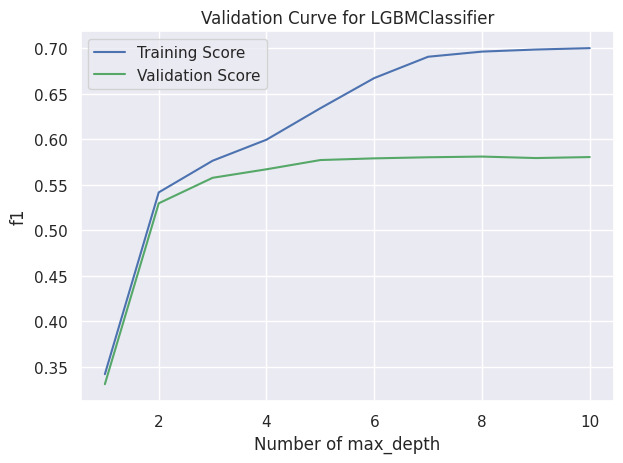

In [29]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=3):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)


val_curve_params(model, X, y, "max_depth", range(1, 11), scoring="f1")

In [30]:
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)

model = LGBMClassifier(verbose=-1).fit(X_smote, y_smote)
cv_results = cross_validate(model, X_smote, y_smote, cv=3, scoring=["accuracy", "f1", "roc_auc"])
f1 = cv_results['test_f1'].mean()
auc = cv_results['test_roc_auc'].mean()
accuracy = cv_results['test_accuracy'].mean()
print(f'f1: {f1:.2f}')
print(f'auc: {auc:.2f}')
print(f'accuracy: {accuracy:.2f}')

f1: 0.82
auc: 0.93
accuracy: 0.84


In [31]:
lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

gs_best = GridSearchCV(model, lightgbm_params, cv=3, n_jobs=-1, verbose=False).fit(X_smote, y_smote)
final_model = model.set_params(**gs_best.best_params_)

cv_results = cross_validate(final_model, X_smote, y_smote, cv=3, scoring=['accuracy', 'f1', 'roc_auc'])
f1 = cv_results['test_f1'].mean()
auc = cv_results['test_roc_auc'].mean()
accuracy = cv_results['test_accuracy'].mean()

print(f'f1: {f1:.2f}')
print(f'auc: {auc:.2f}')
print(f'accuracy: {accuracy:.2f}')

f1: 0.83
auc: 0.94
accuracy: 0.86


In [32]:
lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

gs_best = GridSearchCV(model, lightgbm_params, cv=3, n_jobs=-1, verbose=False).fit(X_smote, y_smote)
final_model = model.set_params(**gs_best.best_params_)

cv_results = cross_validate(final_model, X_smote, y_smote, cv=3, scoring=['accuracy', 'f1', 'roc_auc'])
f1 = cv_results['test_f1'].mean()
auc = cv_results['test_roc_auc'].mean()
accuracy = cv_results['test_accuracy'].mean()

print(f'f1: {f1:.2f}')
print(f'auc: {auc:.2f}')
print(f'accuracy: {accuracy:.2f}')

f1: 0.83
auc: 0.94
accuracy: 0.86


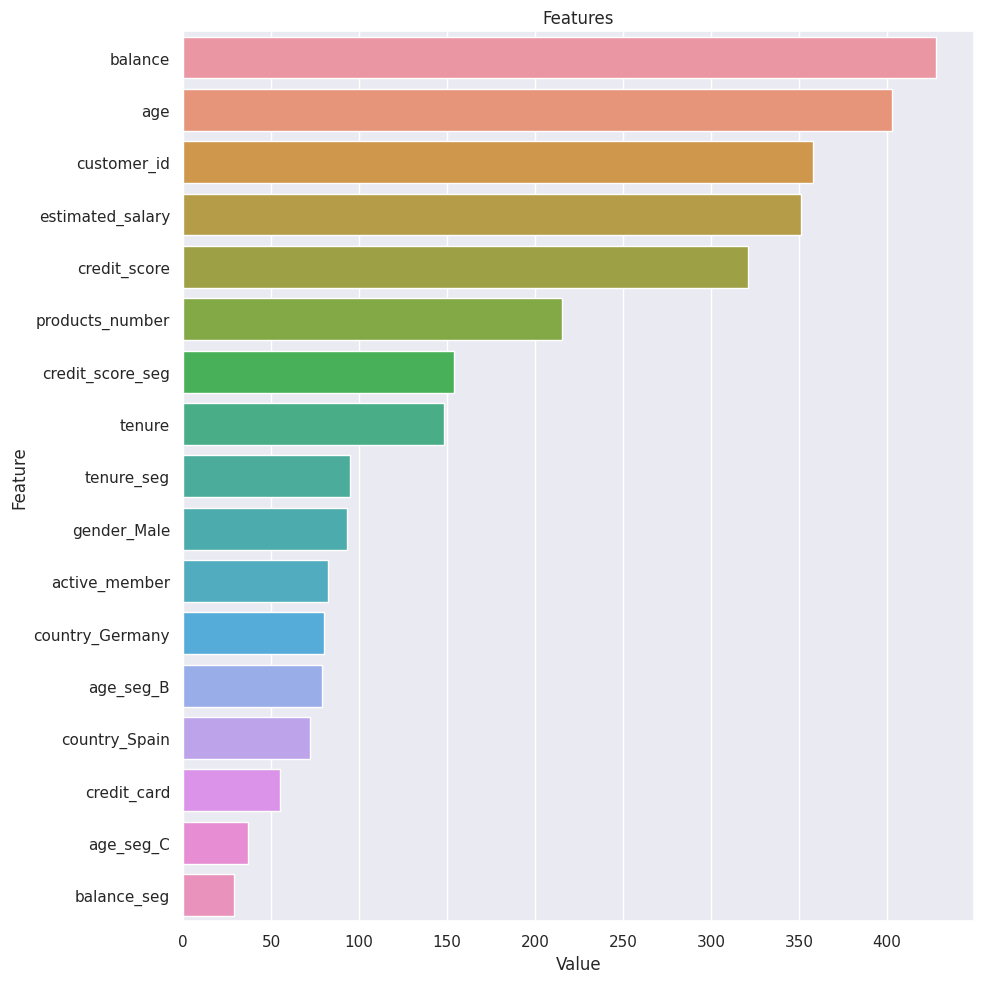

In [33]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(model, X_smote)

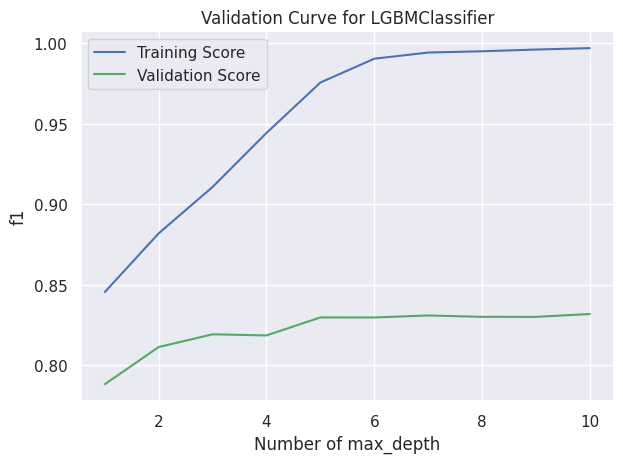

In [34]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=3):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)


val_curve_params(model, X_smote, y_smote, "max_depth", range(1, 11), scoring="f1")